In [1]:
import pandas as pd
import json
import os
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
from typing import Dict, List


def get_readed_coe_df(path: str) -> pd.DataFrame:
    return pd.read_csv(path, header=0)

def get_prediction_errors(df: pd.DataFrame) -> List[float]:
    errors = (df['Timestamp'] - df['NearestEventTimestampNotScaled']).abs()
    errors = errors[errors.isna() == False]
    return errors.tolist()

def get_prediction_errors_for_submethod(submethod_dir: str) -> Dict[str, List[float]]:
    file_prediction_errors_map = dict()
    for file in os.listdir(submethod_dir):
        if file.endswith('.csv'):
            df = get_readed_coe_df(os.path.join(submethod_dir, file))
            file_prediction_errors_map[file] = get_prediction_errors(df)
            
    return file_prediction_errors_map

def get_prediction_errors_for_all_submethods(method_dir: str) -> Dict[str, Dict[str, List[float]]]:
    submethod_prediction_errors_map = dict()
    for submethod in os.listdir(method_dir):
        submethod_dir = os.path.join(method_dir, submethod)
        if os.path.isdir(submethod_dir):
            submethod_prediction_errors_map[submethod] = get_prediction_errors_for_submethod(submethod_dir)
            
    return submethod_prediction_errors_map

def get_df_prediction_errors_for_all_submethods(submethod_prediction_errors_map: Dict[str, Dict[str, List[float]]]) -> pd.DataFrame:
    data = []
    for submethod, file_prediction_errors_map in submethod_prediction_errors_map.items():
        for file, errors in file_prediction_errors_map.items():
            data.extend([(submethod, file, error) for error in errors])
            
    df = pd.DataFrame(data, columns=['submethod', 'file', 'error'])

    df['timestamp'] = df['file'].apply(lambda x: int(x.split('_')[0]))
    df['timestamp_density'] = df['file'].apply(lambda x: int(x.split('_')[1]))

    return df


def get_submethod_label_for_plot(submethod: str) -> str:
    splitted_submethod = submethod.split('_')
    if len(splitted_submethod) == 1:
        return submethod
    else:
        return splitted_submethod[0][0] + splitted_submethod[1]
    
def get_decay(decay_df: pd.DataFrame, coe_df_filename: str) -> float:
    timestamp_file, timestamp = coe_df_filename.split('_')[0:2]

    decay = decay_df[decay_df['timestamp_file'] == timestamp_file]
    decay = decay[decay['timestamp'] == timestamp]
    return decay['decay'].values[0]



In [5]:
submethod_prediction_errors_map = get_prediction_errors_for_all_submethods('data/sampled_coe_dfs')
submethod_prediction_errors_df = get_df_prediction_errors_for_all_submethods(submethod_prediction_errors_map)
submethod_prediction_errors_df.head()

,submethod,file,error,timestamp,timestamp_density
0,naive,1705456527352_1705451719_BI10.csv,0.346,1705456527352,1705451719
1,naive,1705456527352_1705451719_BI10.csv,0.235,1705456527352,1705451719
2,naive,1705456527352_1705451719_BI10.csv,0.321,1705456527352,1705451719
3,naive,1705456527352_1705451719_BI10.csv,0.222,1705456527352,1705451719
4,naive,1705456527352_1705451719_BI10.csv,0.312,1705456527352,1705451719


In [6]:
submethod_prediction_errors_df[submethod_prediction_errors_df['error'] > 15]

,submethod,file,error,timestamp,timestamp_density


In [7]:
submethod_prediction_errors_df[['submethod', 'error']].groupby('submethod').mean().sort_values('error')

,error
submethod,
oracle,0.000000
hawkes_20,0.294841
hawkes_15,0.296710
hawkes_10,0.306279
hawkes_5,0.318055
movingaverage_60,0.340844
movingaverage_30,0.341398
movingaverage_240,0.344199
movingaverage_120,0.345409


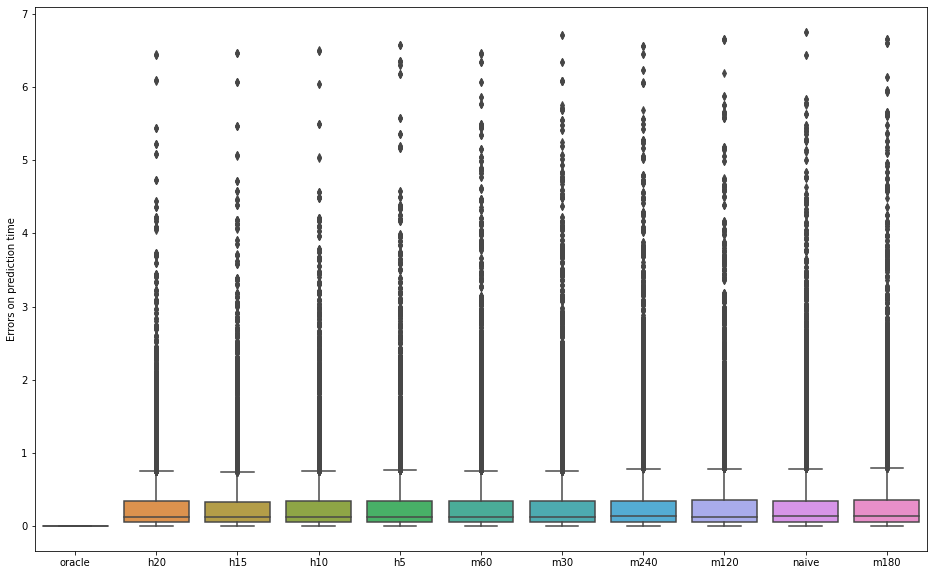

In [8]:
order = submethod_prediction_errors_df.groupby('submethod').mean().sort_values('error').index
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='submethod', y='error', data=submethod_prediction_errors_df,
            showfliers=True, order=order)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})
plt.xlabel(None)

# rename x ticks labels to be more readable
plt.xticks(range(len(order)), [get_submethod_label_for_plot(submethod) for submethod in order])


plt.ylabel('Errors on prediction time')
#put white background
sns.set_style("whitegrid")

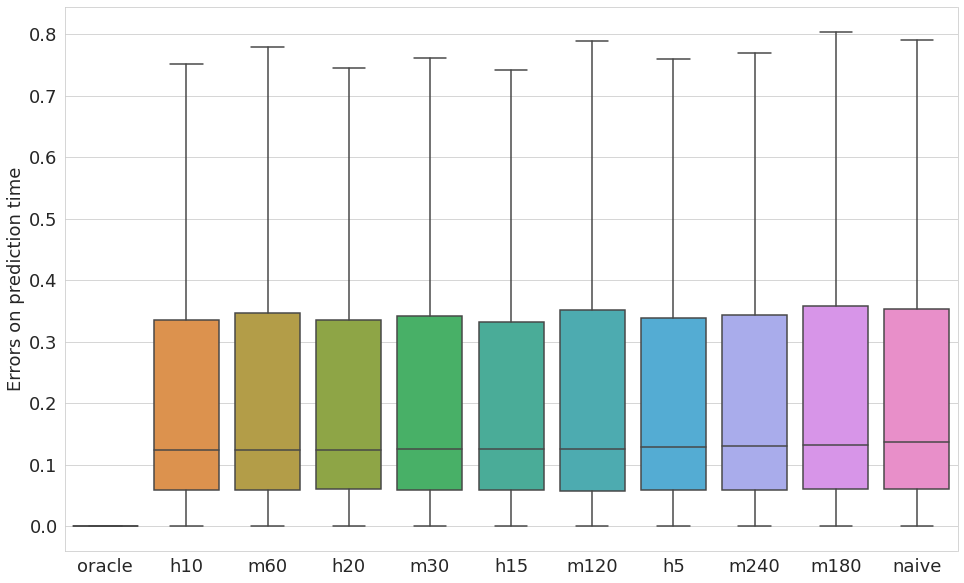

In [12]:
order = submethod_prediction_errors_df.groupby('submethod').median().sort_values('error').index
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='submethod', y='error', data=submethod_prediction_errors_df,
            showfliers=False, order=order)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})
plt.xlabel(None)

# rename x ticks labels to be more readable
plt.xticks(range(len(order)), [get_submethod_label_for_plot(submethod) for submethod in order])


plt.ylabel('Errors on prediction time')
#put white background
sns.set_style("whitegrid")

In [13]:
decay_hawkes5_df = pd.read_csv('data/hawkes_best_decays/hawkes_decay_15min.tsv', sep='\t')
decay_hawkes5_df
submethod_prediction_errors_df = submethod_prediction_errors_df.merge(decay_hawkes5_df, on=['timestamp', 'timestamp_density'])
submethod_prediction_errors_df.head()

,submethod,file,error,timestamp,timestamp_density,decay
0,naive,1705930483445_1705928979_BI8.csv,0.149,1705930483445,1705928979,0.543458
1,naive,1705930483445_1705928979_BI8.csv,0.288,1705930483445,1705928979,0.543458
2,naive,1705930483445_1705928979_BI8.csv,0.033,1705930483445,1705928979,0.543458
3,naive,1705930483445_1705928979_BI8.csv,0.015,1705930483445,1705928979,0.543458
4,naive,1705930483445_1705928979_BI8.csv,0.088,1705930483445,1705928979,0.543458


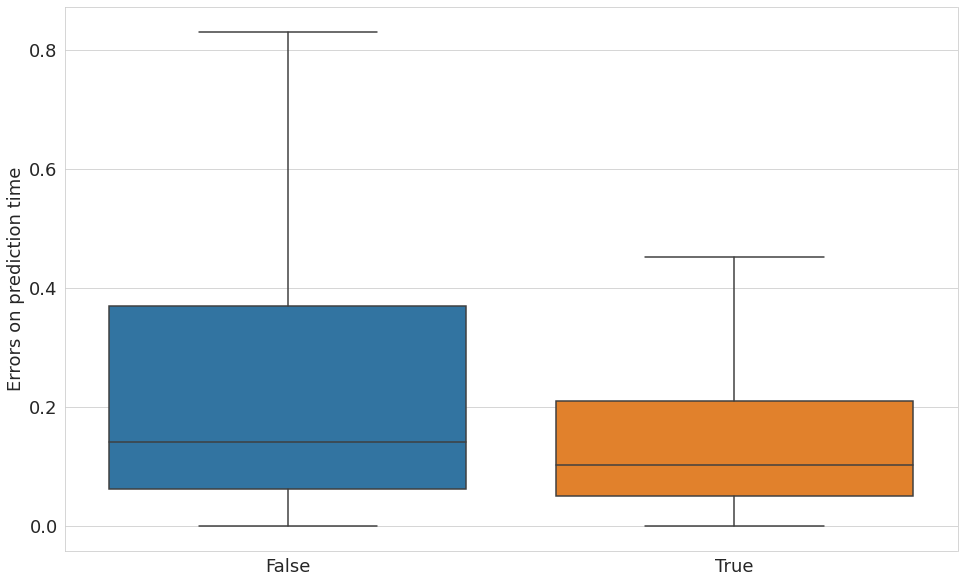

In [14]:
df = submethod_prediction_errors_df[submethod_prediction_errors_df['submethod'] == 'hawkes_15'].copy()
df['beta_saturated'] = df['decay'].apply(lambda x: x == 100)
# boxplot
plt.rcParams["figure.figsize"] = (16,10)
sns.boxplot(x='beta_saturated', y='error', data=df,
            showfliers=False)
# increase font size
#increase plot size
plt.rcParams.update({'font.size': 18})
plt.xlabel(None)

plt.ylabel('Errors on prediction time')
#put white background
sns.set_style("whitegrid")

In [15]:
decay_hawkes5_df[decay_hawkes5_df['decay'] != 100]['decay'].mean()

0.7010703567855952